## Basic example of how integrated gradients work
Johannes Hofmanninger and Philipp Seeböck

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import numpy as np

### We need a network
Here we define a simple neural network architecture that classifies MNIST digits  
...here, we use https://github.com/pytorch/examples/tree/master/mnist

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')
            
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\rTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)), end='')

... now we train the network

In [ ]:
args = {}
args['log_interval'] = 100
args['batch_size'] = 500
args['test_batch_size'] = 500
args['lr'] = 0.01
args['momentum'] = 0.5
args['epochs'] = 10

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

testset = datasets.MNIST('/tmp/data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=args['test_batch_size'],
                                          shuffle=True,
                                          **kwargs)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

let's define an image for which we will calculate the integrated gradients

In [ ]:
# we simply take image 0
testimg = testset[0][0]
plt.imshow(testimg[0]);

here we create the fading examples, from all zero to the final image

In [ ]:
steps = 20
testimgnp  = testimg.detach().cpu().numpy()
baseline = np.ones(testimgnp.shape)*-0.4242 # -0.4242 is the rescaled value for black after normalization of the input
# all the fading images from all zero to the target image are generated
scaled_inputs = np.asarray([baseline + (float(i)/steps)*(testimgnp-baseline) for i in range(0, steps+1)]) 

# note, that you can also start from a randomly initilized baseline

now we can perform the forward passes:

In [ ]:
model.eval()
sm = torch.nn.Softmax(dim=1) # according to the authors we should apply the gradient calculation on a softmax layer

# don't forget to set requires_grad to True for the input images
data = torch.tensor(scaled_inputs, requires_grad=True, dtype=torch.float32).to(device)
output = model(data) # forward pass
pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
output_sc = sm(output) #softmax output as recommended by the authors

In [101]:
targeti = pred[-1].item() # the node (target class) for which we calculate the gradient with respect to the input
# autograd.grad needs a sequence of tensors to calculate independently and these tensors need to be scalars
# here we get 20 scalars (the probabilities of the target class) tensors (one for each sample in the batch of 20 fading images)
xtens = [output_sc[i][targeti] for i in range(len(output_sc))] # xtens is 21x1 vector holding tensors with the probabilities. 21 is the original image
# calculate sum of derivatives with respect to the images
grads = torch.autograd.grad(xtens,data) # grads is a tensor of 21x1x28x28 holding the derivatives
gradsnp = grads[0].detach().cpu().numpy()[:-1] # in the reference implementation, they don't include the gradients for the original image

In [102]:
avg_grads = np.mean(gradsnp, axis=0)
# in the reference implementation, the integrated gradients are masked with the difference between the baseline and the input image
# as the MNIST digits have a black background, this results in masking
integrated_gradients = (testimgnp-baseline)*avg_grads 

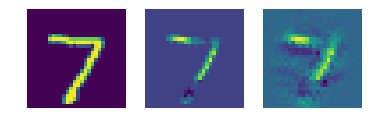

In [103]:
plt.rcParams['image.cmap'] = 'viridis'
ax  = plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(testimgnp[0]);
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(integrated_gradients[0]);
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(avg_grads[0]);
# plt.imshow(grads[0].detach().cpu().numpy()[-1][0])

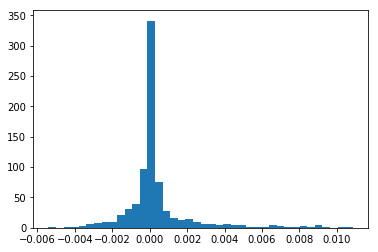

In [104]:
plt.hist(avg_grads.flatten(),bins=40);